In [1]:
import sys
import os

In [47]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install torchinfo

In [4]:
import torch
import torch.nn as nn
from torchinfo import summary
import random
import numpy as np
from pprint import pprint
import joblib
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime
from functools import partial

In [5]:
basepath = "/content/drive/MyDrive/NLP"

In [6]:
sys.path.append("/content/drive/MyDrive/NLP")

In [7]:
basefolder = Path(basepath)
datafolder = basefolder
modelfolder = basefolder
customfolder = basefolder

In [8]:
# Load the dataset
data = joblib.load("/content/drive/MyDrive/NLP/df_multilabel_hw_cleaned.joblib")
data.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47427 entries, 0 to 47426
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cleaned_text  47427 non-null  object
 1   Tags          47427 non-null  object
 2   Tag_Number    47427 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [10]:
data.isnull().sum()

,0
cleaned_text,0
Tags,0
Tag_Number,0


In [11]:
import numpy as np
import ast

def process_data(data):
    # Function to safely convert Tag_Number from string to int, handling errors
    def safe_convert_tag(tag):
        try:
            return ast.literal_eval(tag)
        except (ValueError, SyntaxError):
            return None

    # Using list comprehension to process Tag_Number and cleaned_text
    y = [safe_convert_tag(tag) for tag in data['Tag_Number']]
    x = np.array(data['cleaned_text'].astype(str)).reshape(-1, 1)

    return x, y




x, y = process_data(data)

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y = mlb.fit_transform(y)

print(type(y) , y.shape)
print(type(x) , x.shape)

<class 'numpy.ndarray'> (47427, 10)
<class 'numpy.ndarray'> (47427, 1)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.4,
                                                    random_state=0)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5,
                                                    random_state=0,
                                                    shuffle=False)

In [14]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (28456, 1)
y_train shape: (28456, 10)
X_test shape: (9486, 1)
y_test shape: (9486, 10)
X_valid shape: (9485, 1)
y_valid shape: (9485, 10)


In [15]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading IMDB reviews and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Storing feature data (texts)
        self.X = X

        # Storing the target labels
        self.y = y

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample

In [16]:
# Create an instance of the CustomDataset class for the training set
trainset = CustomDataset(X_train, y_train)

# Create an instance of the CustomDataset class for the validation set
validset = CustomDataset(X_valid, y_valid)

# Create an instance of the CustomDataset class for the test set
testset = CustomDataset(X_test, y_test)

In [17]:
from collections import Counter, OrderedDict
from typing import Dict, List, Optional, Union

class Vocab:
    def __init__(self, tokens: List[str]) -> None:
        self.itos: List[str] = tokens
        self.stoi: Dict[str, int] = {token: i for i, token in enumerate(tokens)}
        self.default_index: Optional[int] = None

    def __getitem__(self, token: str) -> int:
        if token in self.stoi:
            return self.stoi[token]
        if self.default_index is not None:
            return self.default_index
        raise RuntimeError(f"Token '{token}' not found in vocab")

    def __contains__(self, token: str) -> bool:
        return token in self.stoi

    def __len__(self) -> int:
        return len(self.itos)

    def insert_token(self, token: str, index: int) -> None:
        if index < 0 or index > len(self.itos):
            raise ValueError("Index out of range")
        if token in self.stoi:
            old_index = self.stoi[token]
            if old_index < index:
                self.itos.pop(old_index)
                self.itos.insert(index - 1, token)
            else:
                self.itos.pop(old_index)
                self.itos.insert(index, token)
        else:
            self.itos.insert(index, token)

        self.stoi = {token: i for i, token in enumerate(self.itos)}

    def append_token(self, token: str) -> None:
        if token in self.stoi:
            raise RuntimeError(f"Token '{token}' already exists in the vocab")
        self.insert_token(token, len(self.itos))

    def set_default_index(self, index: Optional[int]) -> None:
        self.default_index = index

    def get_default_index(self) -> Optional[int]:
        return self.default_index

    def lookup_token(self, index: int) -> str:
        if 0 <= index < len(self.itos):
            return self.itos[index]
        raise RuntimeError(f"Index {index} out of range")

    def lookup_tokens(self, indices: List[int]) -> List[str]:
        return [self.lookup_token(index) for index in indices]

    def lookup_indices(self, tokens: List[str]) -> List[int]:
        return [self[token] for token in tokens]

    def get_stoi(self) -> Dict[str, int]:
        return self.stoi.copy()

    def get_itos(self) -> List[str]:
        return self.itos.copy()

    @classmethod
    def vocab(cls, ordered_dict: Union[OrderedDict, Counter], min_freq: int = 1, specials: Optional[List[str]] = None, special_first: bool = True) -> 'Vocab':
        specials = specials or []
        for token in specials:
            ordered_dict.pop(token, None)

        tokens = [token for token, freq in ordered_dict.items() if freq >= min_freq]

        if special_first:
            tokens = specials + tokens
        else:
            tokens = tokens + specials

        return cls(tokens)

In [18]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (list of tuple): List of tuples where each tuple contains a label and a text.
        min_freq (int): The minimum frequency for a token to be included in the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object.
    """
    counter = Counter()

    for (label, text) in dataset:
        # Convert text to string if it's a NumPy array
        if isinstance(text, np.ndarray):
            # Join the array elements with spaces before splitting
            text = ' '.join(text.astype(str))
        elif not isinstance(text, str):
            text = str(text)

        counter.update(text.split())

    my_vocab = Vocab.vocab(counter, min_freq=min_freq)
    my_vocab.insert_token('<unk>', 0)
    my_vocab.set_default_index(0)

    return my_vocab

In [19]:
codeData_vocab = get_vocab(trainset,min_freq=2)

In [20]:
print(len(codeData_vocab))

91042


In [21]:
def tokenizer(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(x).split()]

In [22]:
from functools import partial
import torch

def collate_batch(batch, my_vocab):
    """
    Collates a batch of samples into tensors of labels, texts, and offsets.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing three tensors:
               - Labels tensor
               - Concatenated texts tensor
               - Offsets tensor indicating the start positions of each text in the concatenated tensor
    """
    # Unpack the batch into separate lists for labels and texts
    labels, texts = zip(*batch)

    # Convert the list of labels into a tensor of dtype int32
    labels = torch.tensor(labels, dtype=torch.long)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all text indices into a single tensor
    indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return (indices, offsets), labels

In [23]:
batch_size = 2
collate_partial = partial(collate_batch, my_vocab = codeData_vocab)
check_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           collate_fn=collate_partial,
                                           )

In [24]:
class CustomBlock(nn.Module):
    def __init__(self, input_dim, output_dim, drop_prob):

        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(num_features=output_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),

        )
    def forward(self, x):
      return self.layers(x)
class EmbeddingBagWrapper(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

    def forward(self, input_tuple):
        data, offsets = input_tuple
        return self.embedding_bag(data, offsets)

In [25]:
from functools import partial

# Define hyperparameters
EMBED_DIM = 300
VOCAB_SIZE = len(codeData_vocab)
OUTPUT_DIM = 10
HIDDEN_DIM1 = 200
HIDDEN_DIM2 = 100
OUTPUT_DIM = 10
EPOCHS = 5
BATCH_SIZE = 128
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
CLIP_TYPE = 'value'
CLIP_VALUE = 10
PATIENCE = 5
dropout_p = 0.3

# Define collate function
collate_fn = partial(collate_batch, my_vocab=codeData_vocab)

In [26]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the model

# Define the sequential model
vocab_size = len(codeData_vocab)
model = nn.Sequential(
    EmbeddingBagWrapper(vocab_size, EMBED_DIM),
    CustomBlock(EMBED_DIM , HIDDEN_DIM1, 0.5),
    CustomBlock(HIDDEN_DIM1, HIDDEN_DIM2, 0.5),
    nn.Linear(HIDDEN_DIM2, OUTPUT_DIM)
    )

In [27]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

In [28]:
!pip install torchmetrics

In [29]:
from torchmetrics import HammingDistance

def step(inputs, targets, model, device, loss_function=None, optimizer=None, clip_type=None, clip_value=None):
    """
    Perform one training step (forward + backward + optimize).

    Parameters:
    - inputs: Input data.
    - targets: Target labels.
    - model: The model to train.
    - device: The device to run computations on.
    - loss_function: The loss function to use.
    - optimizer: The optimizer to use.
    - clip_type: Type of gradient clipping ('value' or 'norm').
    - clip_value: Value for gradient clipping.

    Returns:
    - loss: The calculated loss.
    - hamming_distance: The Hamming distance between predictions and targets.
    - num_correct: The number of correct predictions.
    """

    # Step 1: Move inputs and targets to the device
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs) # Correct input is a tuple
    targets = targets.to(device) # Move the target to the device

    # Reset gradients if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()

    # Perform the forward pass and get model outputs
    outputs = model(inputs)

    # Cast targets to Long before computing loss
    targets = targets.type(torch.long)

    # Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Update Hamming Distance metric
    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    y_pred = (outputs > 0.5).float()
    train_hamming_distance.update(y_pred, targets)

    # Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        if clip_type == 'value':
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)
        optimizer.step()
           # Return relevant metrics
    if loss_function:
        return loss, outputs, train_hamming_distance
    else:
        return outputs, train_hamming_distance

In [30]:
import torch
from torchmetrics.classification import HammingDistance

def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - epoch_hamming_distance (float): Hamming distance for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0

    # Initialize Hamming Distance metric
    hamming = HammingDistance(task="multilabel", num_labels=10).to(device)

    # Iterate over all batches in the training data
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        # Move inputs and targets to the specified device
        inputs = tuple(input_tensor.to(device) for input_tensor in inputs) if isinstance(inputs, tuple) else inputs.to(device)
        targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform a forward pass to get model outputs
        outputs = model(inputs) # Assigning the output of the model to the variable 'outputs'

        # Compute the loss
        loss = loss_function(outputs, targets.type(torch.float))

        # Update running loss
        running_train_loss += loss.item()

        # Perform backpropagation and optimization step
        loss.backward()
        optimizer.step()

        # Compute Hamming Distance for this batch
        y_pred = (outputs > 0.5).float()
        hamming.update(y_pred, targets)

    # Compute average loss for the entire training set
    train_loss = running_train_loss / len(train_loader)

    # Compute Hamming Distance for the epoch
    epoch_hamming_distance = hamming.compute().item()

    # Reset Hamming distance metric after the epoch
    hamming.reset()

    return train_loss, epoch_hamming_distance

In [31]:
def val_epoch(valid_loader, model, device, loss_function):
    model.eval()
    running_loss = 0.0
    total_hamm_dist = 0

    with torch.no_grad():
        for inputs, targets in valid_loader:
            # Move inputs and targets to the device (CPU or GPU)
            inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
            targets = targets.to(device)

            # Perform a forward pass to get predictions
            outputs = model(inputs)

            # Ensure targets are of the correct type and values
            targets = targets.type(torch.float32) # Convert targets to float32

            # Calculate the loss
            loss = loss_function(outputs, targets)

            # Update running loss
            running_loss += loss.item() * targets.size(0)



    # Calculate average loss and Hamming distance for the epoch
    epoch_loss = running_loss / len(valid_loader.dataset)

    epoch_hamm=0

    return epoch_loss, epoch_hamm

In [32]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience=5):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).
    - patience (int): Number of epochs to wait for improvement before early stopping.

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_hamm_history (list): History of training Hamming distance for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_hamm_history (list): History of validation Hamming distance for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_hamm_history = []
    valid_hamm_history = []

    # Initialize variables for early stopping
    best_valid_loss = float('inf')
    no_improvement = 0

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_hamm = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_hamm = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_hamm_history.append(train_hamm)
        valid_hamm_history.append(valid_hamm)
        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Hamming Distance: {train_hamm:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Hamming Distance: {valid_hamm:.4f}")
        print()

        # Check for early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement == patience:
                print(f"No improvement for {patience} epochs. Early stopping...")
                break

    return train_loss_history, train_hamm_history, valid_loss_history, valid_hamm_history

In [33]:
# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.0
PATIENCE=10

In [34]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Define collate function with a fixed vocabulary using the 'partial' function
collate_fn = partial(collate_batch, my_vocab=codeData_vocab)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=4)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                                          collate_fn=collate_fn, num_workers=4)

# Define the loss function for the model, using cross-entropy loss
loss_function = nn.BCEWithLogitsLoss()

# Define the model with specified hyperparameters
vocab_size = len(codeData_vocab)
model = nn.Sequential(
    EmbeddingBagWrapper(vocab_size, EMBED_DIM),
    CustomBlock(EMBED_DIM , HIDDEN_DIM1, 0.5),
    CustomBlock(HIDDEN_DIM1, HIDDEN_DIM2, 0.5),
    nn.Linear(HIDDEN_DIM2, OUTPUT_DIM)
    )
model = model.to(device)

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
for inputs, targets in train_loader:
    # Move inputs and targets to the CPU.
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
    targets = targets.to(device) # Move targets to the device
    model_fin = model.to(device)
    model_fin.eval()

    # Forward pass
    with torch.no_grad():
        output = model_fin(inputs)

        # Cast targets to float
        loss = loss_function(output, targets.type(torch.float))
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray wit

Actual loss: 0.6915262937545776
Expected Theoretical loss: 0.6931471805599453


In [36]:
CLIP_VALUE = 10
# Call the train function to train the model
train_losses, train_hamm, valid_losses, valid_hamm = train(
    train_loader, valid_loader, model, optimizer, loss_function, EPOCHS, device, patience=PATIENCE
)

<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.t

Epoch 1/5
Train Loss: 0.2935 | Train Hamming Distance: 0.1135
Valid Loss: 0.1694 | Valid Hamming Distance: 0.0000



<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.t

Epoch 2/5
Train Loss: 0.1663 | Train Hamming Distance: 0.0635
Valid Loss: 0.1377 | Valid Hamming Distance: 0.0000



<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.t

Epoch 3/5
Train Loss: 0.1380 | Train Hamming Distance: 0.0526
Valid Loss: 0.1240 | Valid Hamming Distance: 0.0000



<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.t

Epoch 4/5
Train Loss: 0.1193 | Train Hamming Distance: 0.0455
Valid Loss: 0.1154 | Valid Hamming Distance: 0.0000



<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.t

Epoch 5/5
Train Loss: 0.1065 | Train Hamming Distance: 0.0406
Valid Loss: 0.1115 | Valid Hamming Distance: 0.0000



In [37]:
import matplotlib.pyplot as plt

def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")
    if val_losses is not None and len(val_losses) > 0:
        plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Epochs")
    plt.show()

    # Plotting training and validation metrics (e.g., Hamming loss)
    if train_metrics[0] is not None:
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train Metric")
        if val_metrics is not None and len(val_metrics) > 0:
            plt.plot(epochs, val_metrics, label="Validation Metric")
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.title("Metrics Over Epochs")
        plt.show()


In [38]:
import numpy as np

# Helper function to convert tensors to NumPy arrays (CPU if needed)
def tensor_to_numpy(tensor_list):
    return [t.cpu().numpy() if hasattr(t, 'cpu') else t for t in tensor_list]

# Convert train_hamm and valid_hamm to numpy arrays
train_hamm_np = tensor_to_numpy(train_hamm)
valid_hamm_np = tensor_to_numpy(valid_hamm)


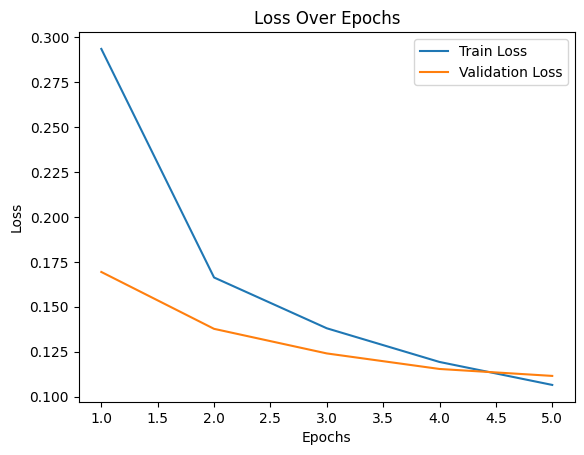

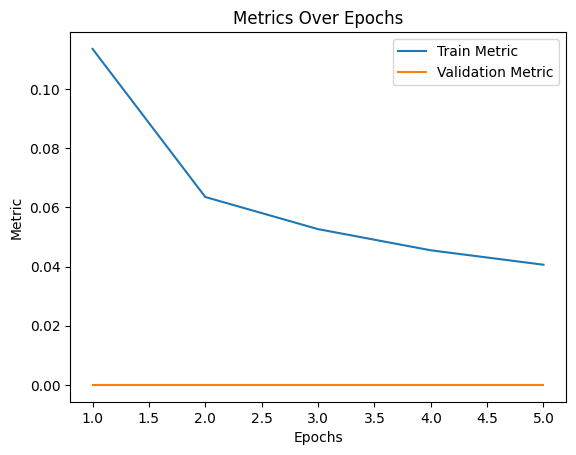

In [39]:
# Plot the training and validation losses and metrics (e.g., Hamming loss)
plot_history(train_losses, train_hamm_np, valid_losses, valid_hamm_np)


In [40]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)

    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            outputs, _ = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            # Correct prediction using thresholding
            y_pred = (outputs.data>0.5).float()

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, y_pred))
            y = torch.cat((y, targets.to(device)))

    # Calculate accuracy by comparing the predicted and actual labels
    accuracy = (predictions == y).float().mean()

    # Return tuple containing predictions and accuracy
    return predictions, accuracy, y

In [41]:
# Get the prediction and accuracy
predictions_test, acc_test, y_test = get_acc_pred(test_loader, model, device)
predictions_train, acc_train, y_train = get_acc_pred(train_loader, model, device)
predictions_valid, acc_valid, y_valid = get_acc_pred(valid_loader, model, device)

<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-22-290ee004b6c2>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.t

In [42]:
# Print Test Accuracy
print('Valid accuracy', acc_valid * 100)

Valid accuracy tensor(95.7312)


In [43]:
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = multilabel_confusion_matrix(valid_labels, valid_preds)

    # Plot the confusion matrix using Seaborn
    fig, axs = plt.subplots(1, len(class_labels), figsize=(15, 5))
    for i, (label, matrix) in enumerate(zip(class_labels, cm)):
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Reds", xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axs[i])
        axs[i].set_title(f"Confusion Matrix for Class {label}")
        axs[i].set_xlabel('Predicted Labels')
        axs[i].set_ylabel('True Labels')

    # Display the plot
    plt.tight_layout()
    plt.show()

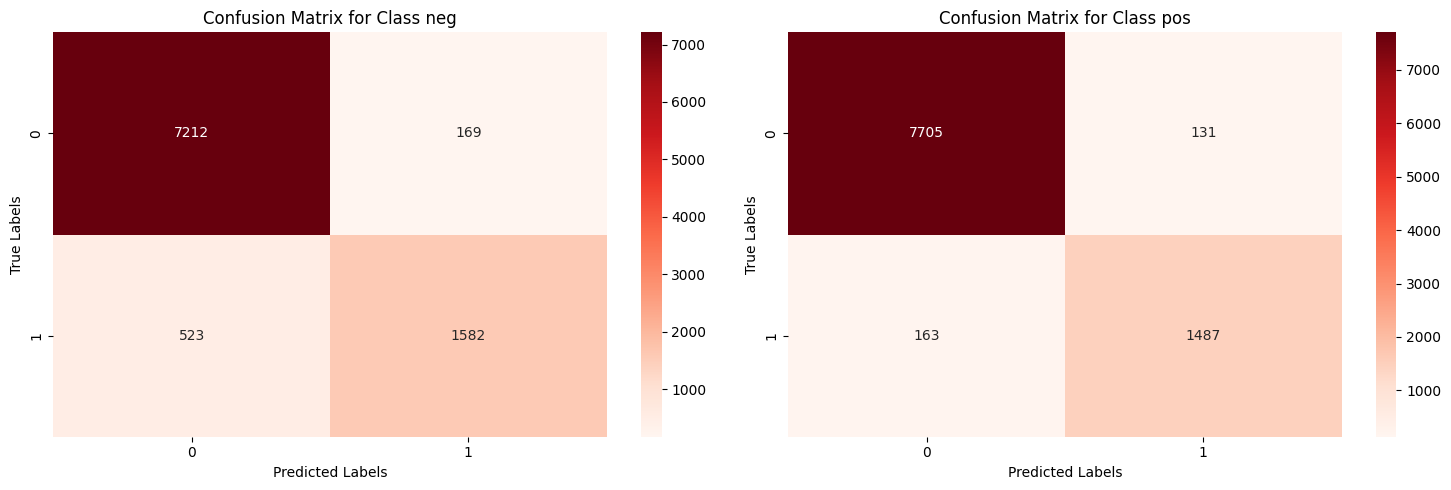

In [44]:
plot_confusion_matrix(y_test.cpu().numpy(),
                      predictions_test.cpu().numpy(),
                      class_labels=['neg', 'pos'])

In [45]:
test_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
test_hamming_distance.update(y_test, predictions_test)

In [46]:
test_hamming_distance.compute()

tensor(0.0458)

Inferences

Loss Over Epochs:

The training loss shows a steady decline over the 5 epochs, starting at approximately 0.29 and finishing around 0.11.
Similarly, the validation loss decreases throughout the epochs, beginning at a value lower than the training loss and converging close to 0.10 by epoch 5.

Inference for Loss Plot:

The decrease in both training and validation loss is a positive indication that the model is learning effectively and improving on both datasets. Overall, the validation loss remains consistently lower than the training loss at each epoch, suggesting that the model does not overfit and generalizes well to unseen validation data.

Metric Over Epochs:

Training Metric: The blue line, representing the Hamming loss on the training set, starts near 0.10 and drops to around 0.03 by epoch 5.

Validation Metric: The orange line remains relatively stable at a low value throughout all epochs, indicating strong performance on the validation set.

As the training metric improves with each iteration, it suggests that the model enhances its predictions for the training data. The validation metric's consistency at a low value from the outset implies that the model generalizes effectively to the validation set. Overall, these trends indicate that the model is learning well, generalizing effectively, and exhibiting minimal overfitting.

Confusion Matrix:

The counts of true positives are relatively balanced between the two classes, indicating satisfactory performance in accurately identifying positive samples.
Both classes exhibit good precision and recall, particularly for the 'pos' class, where the model makes fewer errors.
The low counts of both false positives and false negatives further suggest that the model is performing well in this classification task, demonstrating effective predictions overall.